# Workflow 1: Train Use Chips and Masks Saved to Disk

This first workflow demonstrates training a model using DTM chips and associated masks that have been pre-generated and stored on disk. 

## Load Packages

In [3]:
import sys

from terrainseg.models.customunet import defineCUNet
from terrainseg.models.unet import defineUNet
from terrainseg.models.convnextunet import defineCNXTUNet
from terrainseg.utils.chips import (makeMasks, makeChips, makeChipsDF, makeChipsMulticlass)
from terrainseg.utils.dynamicchips import (makeDynamicChipsGDF, checkDynamicChips, saveDynamicChips)
from terrainseg.utils.spatialpredict import (terrainPredict)
from terrainseg.utils.trainer import (terrainDataset, terrainDatasetDynamic, terrainTrainer, terrainSegModel, unifiedFocalLoss)
from terrainseg.utils.checks import viewBatch

import torch
from torch.utils.data import DataLoader
import rasterio as rio
import pandas as pd
import albumentations as A

## Step 1: Make Masks

The `makeMasks()` function is used to convert polygon vector data to categorical raster data. It requires providing an input DTM, which is used as a template raster, input polygon vector features, and an attribute column of numeric codes that differentiate each class. A value can also be specified for the `background` class, or areas occurring outside the reference polygons. 

The `crop` option specifies whether or not the mask should be cropped to a defined `extent`. The `mode` can be either `"Both"` or `"Mask"`. When using `"Both"`, a copy of the DTM is produced alongside the mask. This is helpful if you want to crop the DTM relative to an extent and so that the DTM and mask align perfectly and have the same number of rows and columns of cells.

When assigning codes to classes, we recommend reserving 0 for the background class and ordering all other classes sequentially. For example, if you have 4 classes plus the background, you would use codes 0 through 4. For a binary classification, 0 should represent the background class and 1 should represent the positive case. 

In [ ]:
makeMasks(
    image= "C:/sub/trainSub.tif",
    features= "C:/sub/trainSub.shp",
    crop = True,
    extent = "C:/sub/trainSubExt.shp",
    field = "code",
    background = 0,
    out_image = "C:/sub/dtm2.tif",
    out_mask = "C:/sub/vfillR.tif",
    mode = "Both",
    all_touched = False,
    dtype = "uint8",
)

## Step 2: Make Chips

Once raster masks are generated that align with the DTM, the DTM and aligned mask can be broken into chips of a defined size using the `makeChips()` or `makeChipsMulticlass()` function. `makeChips()` should be used when there are only two codes, 0 and 1, while `makeChipsMultiClass()` should be used when there are more than two classes differentiated.

The `makeChips()` function requires specifying the input DTM and mask raster grids. The generated chips are saved to a directory indicated by the `out_dir` parameter. Inside this directory, the function will generate “images” and “masks” sub-directories. The `size` argument specifies the size of each chip and mask (256x256 cells in the example). The `stride_x` and `stride_y` parameters specify how far the moving window moves or shifts in the x and y directions as the chips are generated. If strides smaller than the chip size are used, overlapping chips are generated.

For a binary classification, three options are available for `mode`. `"All"` indicates that all chips are produced including those that contain no cells mapped to the positive case. In contrast, `"Positive"` indicates that only chips that have at least one cell mapped to the positive case are generated. Lastly, `"Divided"` indicates that all chips are generated; however, chips that contain only background cells are saved to a separate “Background” directory while those that contain at least one cell mapped to the positive case are saved to the “Positive” directory. 

You can also save chips to a folder that already exists and contains chips generated from other predictor variable/mask pairs using `use_existing_dir=True`. This is useful if you want to merge chips generated from multiple DTM and mask pairs representing different geographic extents into the same folder. 

In [ ]:
makeChips(
    image ="C:/sub/dtm2.tif",
    mask ="C:/sub/vfillR.tif",
    n_channels = 1,
    size = 256,
    stride_x = 256,
    stride_y = 256,
    out_dir = "C:/sub/chips/",
    mode = "All",
    use_existing_dir = False
)

## Step 3: Make Chips Data Frames

Once chips are created and saved in a specified directory using `makeChips()` or `makeChipsMulticlass()`, they can be listed into a Pandas DataFrame using `makeChipsDF()`. As with` makeChips()`, for a binary classification, the same three options are available for `mode`. For a multiclass classification, you should use`'mode = "All"`. For both the binary and multiclass problem types, the generated `“chpN”` column provides the name of the chip while the `“chpPth”` and `“mskPth”` columns list the paths to the images and masks, respectively. For a binary classification and when using `mode="Divided"`, a `“Division”` column is added to indicate whether the chip is a background-only or positive case-containing sample.

In [4]:
trainDF = makeChipsDF(
    folder ="C:/sub/chips/",
    out_csv = None,
    extension = ".tif",
    mode = "All",
    shuffle = False,
    save_csv = False,
    seed = None,
)

In [5]:
print(trainDF)

                   chpN                                  chpPth  \
0    dtm2_1025_1025.tif  C:\sub\chips\images\dtm2_1025_1025.tif   
1    dtm2_1025_1281.tif  C:\sub\chips\images\dtm2_1025_1281.tif   
2    dtm2_1025_1537.tif  C:\sub\chips\images\dtm2_1025_1537.tif   
3    dtm2_1025_1793.tif  C:\sub\chips\images\dtm2_1025_1793.tif   
4    dtm2_1025_2049.tif  C:\sub\chips\images\dtm2_1025_2049.tif   
..                  ...                                     ...   
395   dtm2_769_3585.tif   C:\sub\chips\images\dtm2_769_3585.tif   
396   dtm2_769_3841.tif   C:\sub\chips\images\dtm2_769_3841.tif   
397   dtm2_769_4097.tif   C:\sub\chips\images\dtm2_769_4097.tif   
398    dtm2_769_513.tif    C:\sub\chips\images\dtm2_769_513.tif   
399    dtm2_769_769.tif    C:\sub\chips\images\dtm2_769_769.tif   

                                    mskPth  
0    C:\sub\chips\masks\dtm2_1025_1025.tif  
1    C:\sub\chips\masks\dtm2_1025_1281.tif  
2    C:\sub\chips\masks\dtm2_1025_1537.tif  
3    C:\sub\chi

## Step 4: Check a Batch

A random subset of chips can be visualized using the `viewChips()` function. The function requires providing a Pandas DataFrame created with `makeChipsDF()`. The user must also specify the integer or code assigned to each class (`cCodes`), name of each class (`cNames`), and color to use to display each class (`cColors`). 

Before using this function, a mini-batch of pairs of chips and masks must be extracted by (1) instantiating a DataSet using `terrainDataset()`, (2) instantiating a PyTorch DataLoader, and (3) extracting out a mini-batch using `next(iter())`. 

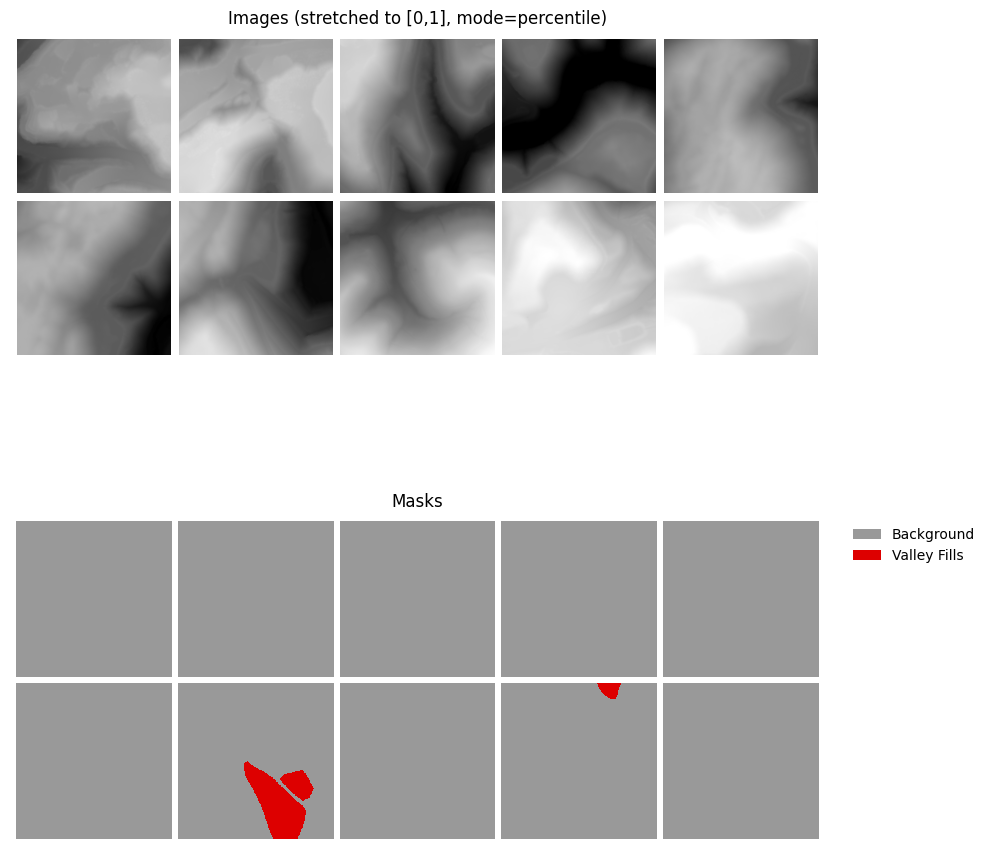

In [6]:
trainDS = terrainDataset(df=trainDF, transform=None)

trainDL = DataLoader(trainDS, batch_size=10)
batch = next(iter(trainDL))

viewBatch(dataloader=trainDL,
        ncols = 5,
        cCodes = (0,1),
        cNames= ("Background", "Valley Fills"),
        cColors= ("#999999", "#DD0000"),
        padding = 10,
        figsize=(10, 10),
        mask_mode = "auto",
        stretch = "percentile",          
        p_low = 2.0,                  
        p_high = 98.0)

## Step 5: Train Model

To train a model, the user must:

1. Instantiate the trainable component of the model. If not using Gaussian pyramids, the number of input channels should be 6. If using Gaussian pyramids, the number of input channels should be 31. 
2. Define a loss function or criterion. Below, we are using the unified focal loss provided by `terrainseg`. However, other loss functions can be used. 
3. Train the model using `terrainTrainer()`. This function saves the model checkpoint, or state after a specific training epoch, to disk that yields the highest F1-score. It also saves a CSV log file of the training and validation loss and assessment metric values per epoch. 

As explained below, `terrainseg` provides functions for generating a UNet model (`defineUNet()`), a customizable UNet with added modules (`defineCustomUNet()`), and UNet with a ConvNeXt-style encoder and attention gates along the skip connections (`defineCNXTUNet()`). It is also possible to use models generated by other libraries, such as those from [Segmentation Models](https://github.com/qubvel-org/segmentation_models.pytorch). Users can also define their own custom models by subclassing `nn.module()`.

Our models are designed to return logits for each predicted class with tensors of shape `[mini-batch size, number of classes, height, width]`. When using alternative loss functions, users should determine what output is expected: logits or rescaled logits generated using a softmax or sigmoid function. 

It is also possible to use a custom training loop as opposed to the one implemented by our `terrainTrainer()` function. 

In [ ]:
trainDF = makeChipsDF(
    folder ="C:/22318522/chips/train/",
    out_csv = None,
    extension = ".tif",
    mode = "All",
    shuffle = False,
    save_csv = False,
    seed = None,
)

valDF = makeChipsDF(
    folder ="C:/22318522/chips/val/",
    out_csv = None,
    extension = ".tif",
    mode = "All",
    shuffle = False,
    save_csv = False,
    seed = None,
)

In [ ]:
model = defineUNet(encoderChn=(16,32,64,128), 
                   decoderChn=(128,64,32,16), 
                   inChn=31, 
                   botChn=256, 
                   nCls=2).to("cuda")

In [ ]:
criterion = unifiedFocalLoss(nCls=2,
                lambda_=0,
                gamma=0.7,
                delta=0.6,
                smooth=1e-8,
                zeroStart=True,
                clsWghtsDist=1,
                clsWghtsReg=[0.3, 0.7],
                useLogCosH=False,
                device="cuda")
criterion.__name__ = 'unified_focal_loss' #Requires a name parameter

In [ ]:
terrainTrainer(saveFolder="/data/terrainSegTests/modelOut1/",
                   trainDF=trainDF, 
                   valDF=valDF,
                   trainableModel=model,
                   lossFnc= criterion,
                   nCls=2,
                   do_gp = True,
                   cropFactor=64,
                   epochs=25,
                   batchSize=10,
                   lr=0.0001,
                   cell_size = 1,
                   spat_dim = 640,
                   inner_radius = 2.0,
                   outer_radius = 10.0,
                   hs_radius = 50.0,
                   smooth_radius = 11.0,
                   device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                   doMultiGPU=True)

## Step 6: Use Model

Once a model has been trained, it can be used by:

1. Re-instantiating the model with the same settings used during training.
2. Providing this trainable model to the `terrainSegModel()` function and specifying the settings for the LSP module used during training. 
3. Loading the saved checkpoint. Note that the code below assumes that the model was trained on multiple GPUs using `nn.DataParallel()`. If the model was not trained using multiple GPUs, a checkpoint can be loaded using `load_state_dict()` without the prior modifications. 
4. Predicting the new DTM extent using the `terrainPredict()` function. We recommend including cropping (`crop`) and overlap with the `stride_x` and `stride_y` parameters set to values smaller than the `cell_size` so that only the center of processed chips are used in the final, merged surface. Note that edge predictions will be used on the edge of the raster extent being processed. These settings only apply to interior windows. We have found the setting used below to work well. 

In [ ]:
model = defineUNet(encoderChn=(16,32,64,128), 
                   decoderChn=(128,64,32,16), 
                   inChn=31, 
                   botChn=256, 
                   nCls=2).to("cuda").to("cuda")


modelT = terrainSegModel(modelIn=model,
            cell_size= 1.0,
            spat_dim= 640,
            t_crop= 0,
            do_gp= True,
            inner_radius = 2.0,
            outer_radius= 10.0,
            hs_radius= 50.0,
            smooth_radius = 11.0,
    ).to("cuda")

In [ ]:
checkpoint = torch.load("C:/22318522/models/model.pt", map_location="cuda")

state_dict = checkpoint["state_dict"] if "state_dict" in checkpoint else checkpoint

# Remove 'module.' prefix
new_state_dict = {
    k.replace("module.", "", 1): v
    for k, v in state_dict.items()
}

modelT.load_state_dict(new_state_dict)

In [ ]:
terrainPredict(image_in="C:/22318522/preds/testDTM.tif", 
               pred_out="C:/22318522/preds/testPreds.tif", 
               model=modelT, 
               chip_size=640, 
               stride_x=256, 
               stride_y=256, 
               crop=64, 
               device="cuda")

# Workflow 2: Using Dynamic Chips

## Step 1: Define Dynamic Chips GeoPandas Object

Instead of using chips and masks saved to disk, models can be trained using chips and masks that are dynamically generated during the training loop. The `makeDynamicChipsGDF()` function generates a GeoPandas DataFrame used to guide the generation of chips during the training process. 
This function requires the user to provide the path to point or polygon features that define the center coordinates of the chips to generate (`center_featPth` and `center_featName`). If polygons are provided, the centroid of polygons define the center of the chips. The user must also provide the path to the polygon vector features that will be converted to raster masks (`mask_featPth` and `mask_featName`), a polygon defining the processing extent (`extentPth` and `extentName`), and an input DTM (`imgPth` and `imgName`). The rows in the generated GeoPandas DataFrame can be shuffled using `do_shuffle()`, and this shuffling can be made reproducible with `use_seed=True`. The seed value can be set with `seed`. Note that it is assumed that the mask polygon features contain a `"code"` field of integer values that differentiate classes. By default, the background class is assigned a value of 0. 

When using polygon centroids to define chip centers, the function can generate random points to serve as additional background chips using `do_background = True`. The user can specify the number of background chips to generate (`background_cnt`) and a minimal allowed distance to the nearest polygon centroid (`background_dist`). 

We recommend cropping outer margins using the `extent_crop` function to avoid generating incomplete chips. 

If you would like to merge multiple sets into a single GeoPandas DataFrame, such as when you have multiple training or validation extents, `makeDynamicChipsGDF()` can be ran multiple times and the results can be merged and subsequently shuffled if desired.


In [8]:
valGDF = makeDynamicChipsGDF(
    center_featPth = "C:/22318522/vfillDL/vfillDL/vectors/",
    center_featName = "testingKY1.shp",
    mask_featPth = "C:/22318522/vfillDL/vfillDL/vectors/",
    mask_featName = "testingKY1.shp",
    extentPth = "C:/22318522/vfillDL/vfillDL/extents/",
    extentName = "testingKY1.shp",
    extent_crop = 50.0,
    imgPth = "C:/22318522/vfillDL/vfillDL/dems/",
    imgName = "ky1_dem.tif",
    do_background = False,
    background_cnt  = 0,
    background_dist  = 0.0,
    use_seed = False,
    seed = 42,
    do_shuffle = False,
)

trainGDF = makeDynamicChipsGDF(
    center_featPth = "C:/22318522/vfillDL/vfillDL/vectors/",
    center_featName = "training.shp",
    mask_featPth = "C:/22318522/vfillDL/vfillDL/vectors/",
    mask_featName = "training.shp",
    extentPth = "C:/22318522/vfillDL/vfillDL/extents/",
    extentName = "training.shp",
    extent_crop = 50.0,
    imgPth = "C:/22318522/vfillDL/vfillDL/dems/",
    imgName = "train_dem.img",
    do_background = False,
    background_cnt  = 0,
    background_dist  = 0.0,
    use_seed = False,
    seed = 42,
    do_shuffle = True,
)

In [9]:
len(trainGDF), len(valGDF)

(1105, 553)

In [10]:
print(trainGDF)

      chipID                        geometry  \
0          1   POINT (419679.02 4217267.611)   
1          2  POINT (424040.959 4218292.538)   
2          3  POINT (411319.034 4168217.098)   
3          4  POINT (409380.931 4173870.747)   
4          5  POINT (411127.332 4156244.467)   
...      ...                             ...   
1100    1101  POINT (430304.613 4196541.427)   
1101    1102  POINT (415317.292 4162367.693)   
1102    1103  POINT (404603.071 4176476.654)   
1103    1104  POINT (421740.543 4165870.648)   
1104    1105  POINT (472716.696 4193377.717)   

                                 imgPth        imgName  \
0     C:/22318522/vfillDL/vfillDL/dems/  train_dem.img   
1     C:/22318522/vfillDL/vfillDL/dems/  train_dem.img   
2     C:/22318522/vfillDL/vfillDL/dems/  train_dem.img   
3     C:/22318522/vfillDL/vfillDL/dems/  train_dem.img   
4     C:/22318522/vfillDL/vfillDL/dems/  train_dem.img   
...                                 ...            ...   
1100  C:/22318522

## Step 2: Check Dynamic Chips

Chips and masks must meet the following criteria to be used in a model:

1. Contain a full set of rows and columns for both the DTM and mask data
2. Have no Null, NA, or NoData pixels in the DTM and mask data

After creating a GeoPandas DataFrame with `makeDynamicChipsGDF()`, each chip should be evaluated with `checkDynamicChips()`. This adds additional columns to the data frame, which are then used to filter out chip and mask pairs that are incomplete. We recommend always running these checks and removing incomplete chip and mask pairs from the dynamic dataset to avoid errors. 

It is not necessary to save the dynamic chips to disk; however, if you want to save them, this can be accomplished using `saveDynamicChips()`. The saved chip and mask pairs could then be used within the workflow described above (Workflow 1). 

Lastly, it is not necessary that the training and validation data use the same method. For example, the training data could be generated using the dynamic chips workflow while the validation chips could be created using pre-generated chips.  

As with the first workflow, a mini-batch of dynamically generated chips can be visualized using the `viewBatch()` function.

In [11]:
valGDF = checkDynamicChips(
    chips_gdf = valGDF,
    chip_size = 640,
    cell_size = 2.0,
    nodata_ok = False)

trainGDF = checkDynamicChips(
    chips_gdf = trainGDF,
    chip_size = 640,
    cell_size = 2.0,
    nodata_ok = False)

In [12]:
len(trainGDF), len(valGDF)

(1079, 532)

In [13]:
print(trainGDF)

      chipID                        geometry  \
0          1   POINT (419679.02 4217267.611)   
1          2  POINT (424040.959 4218292.538)   
2          3  POINT (411319.034 4168217.098)   
3          4  POINT (409380.931 4173870.747)   
4          5  POINT (411127.332 4156244.467)   
...      ...                             ...   
1099    1100  POINT (439764.067 4229356.634)   
1100    1101  POINT (430304.613 4196541.427)   
1101    1102  POINT (415317.292 4162367.693)   
1102    1103  POINT (404603.071 4176476.654)   
1103    1104  POINT (421740.543 4165870.648)   

                                 imgPth        imgName  \
0     C:/22318522/vfillDL/vfillDL/dems/  train_dem.img   
1     C:/22318522/vfillDL/vfillDL/dems/  train_dem.img   
2     C:/22318522/vfillDL/vfillDL/dems/  train_dem.img   
3     C:/22318522/vfillDL/vfillDL/dems/  train_dem.img   
4     C:/22318522/vfillDL/vfillDL/dems/  train_dem.img   
...                                 ...            ...   
1099  C:/22318522

As with the first workflow, a mini-batch of dynamically generated chips can be visualized using the `viewBatch()` function. 

In [ ]:
augProb=0.3
myTransforms = A.Compose([A.HorizontalFlip(p=augProb),
                                    A.VerticalFlip(p=augProb),
                                    A.RandomRotate90(p=augProb),])

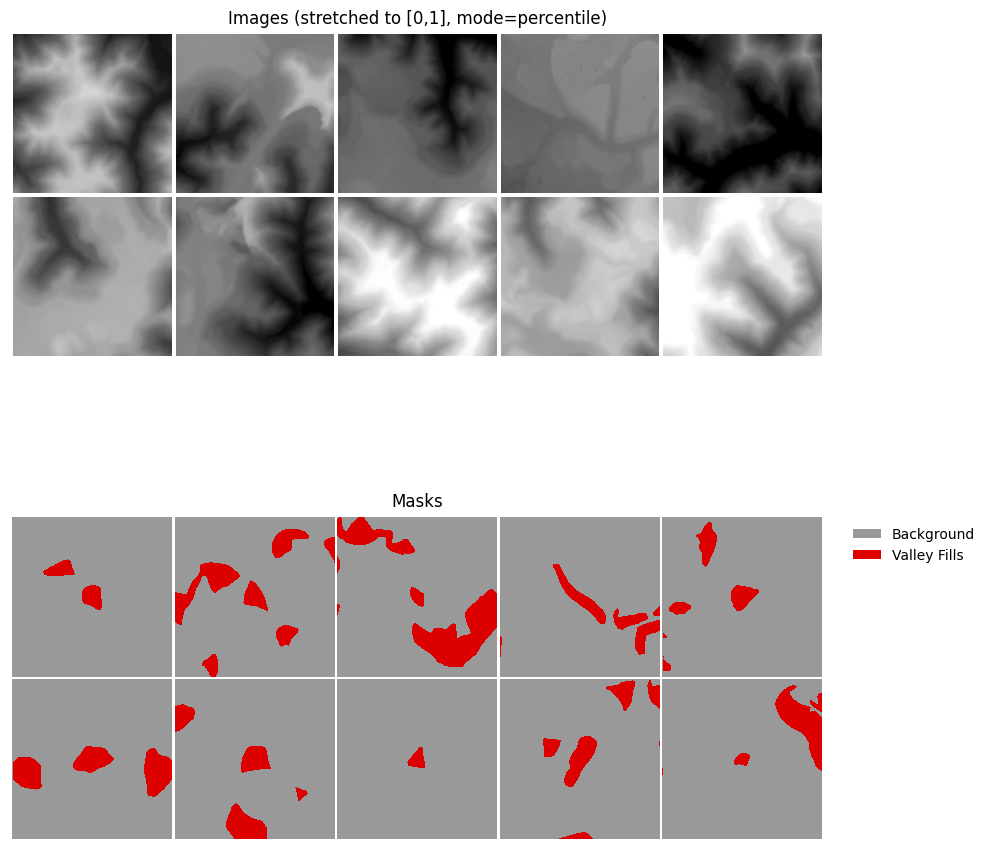

In [15]:
trainDS = terrainDatasetDynamic(df=valGDF, chip_size=640, cell_size=2, background_value=0, transforms=None)

trainDL = DataLoader(trainDS, batch_size=10, shuffle=True)
batch = next(iter(trainDL))

viewBatch(dataloader=trainDL,
        ncols = 5,
        cCodes = (0,1),
        cNames= ("Background", "Valley Fills"),
        cColors= ("#999999", "#DD0000"),
        padding = 10,
        figsize=(10, 10),
        mask_mode = "auto",
        stretch = "percentile",          
        p_low = 2.0,                  
        p_high = 98.0)

## Step 3: Train Model

The training loop when using dynamic chips is the same as when using pre-generated chips. As noted above, it is possible to mix chip generation methods. For example, dynamic chips could be used to train the model while pre-generated chips could be used for validation. 

The processes of loading the model and using it to make predictions to a new geographic extend and/or new DTM data are also identical to the first workflow.

In [ ]:
model = defineUNet(encoderChn=(16,32,64,128), 
                   decoderChn=(128,64,32,16), 
                   inChn=31, 
                   botChn=256, 
                   nCls=2).to("cuda")

In [ ]:
criterion = unifiedFocalLoss(nCls=2,
                lambda_=0,
                gamma=0.7,
                delta=0.6,
                smooth=1e-8,
                zeroStart=True,
                clsWghtsDist=1,
                clsWghtsReg=[0.3, 0.7],
                useLogCosH=False,
                device="cuda")
criterion.__name__ = 'unified_focal_loss' #Requires a name parameter

In [ ]:
terrainTrainer(saveFolder="C:/22318522/models/dynamicModel/",
                   trainDF=trainGDF, 
                   valDF=valGDF,
                   trainableModel=model,
                   lossFnc= criterion,
                   useDynamicTrain = True,
                   useDynamicVal = True,
                   nCls=2,
                   do_gp = True,
                   cropFactor=64,
                   epochs=25,
                   batchSize=8,
                   lr=0.0001,
                   cell_size = 2,
                   spat_dim = 640,
                   inner_radius = 2.0,
                   outer_radius = 10.0,
                   hs_radius = 50.0,
                   smooth_radius = 11.0,
                   device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                   doMultiGPU=False,
                   doFlips=True,
                   doRotate90=True,
                   augProb=0.3)

# Models

The `terrainseg` package provides several semantic segmentation models as described below. You can also use your own custom models or those generated by other packages. The workflow generally assumes that a class logit is predicted for each class at each cell location with the shape `[mini-batch size, number of output classes, width, height]`.

1. `defineUNet()`: Define a UNet with 4 encoder blocks, a bottleneck, and 4 decoder blocks. The user can specify the number of input channels (`inChn`), number of output classes (`ncls`), number of feature maps generated by each encoder block (`enChn`), number of feature maps generated by the bottleneck (`botChn`), and number of feature maps generated by each decoder block (`decoderChn`). The model returns a logit for each class at each cell location with the shape `[mini-batch size, number of output classes, width, height]`.
2. `defineCustomUNet()`: Define a custom UNet with 4 encoder blocks, a bottleneck, and 4 decoder blocks. The user can specify the number of input channels (`in_chn`), number of output classes (`n_Cls`), number of feature maps generated by each encoder block (`en_chn`), number of feature maps generated by the bottleneck (`btn_chn`), and number of feature maps generated by each decoder block (`dc_chn`). The rectified linear unit (ReLU), leaky ReLU, or swish activation function (`act_func`) can be used throughout the architecture and the user can choose to include attention gates along the skip connections (`use_attn`), squeeze and excitation modules in the encoder (`use_se`), residual connections around all double-convolution blocks (`use_res`), and/or replace the default bottleneck with an atrous spatial pyramid pooling (ASPP) module (`use_aspp`). If leaky ReLU is used, the negative slope term can be specified (`negative_slope`). If squeeze and excitation modules are used, the reduction ratio can be defined (`se_ratio`). If an ASSP-based bottleneck is used, the user can specify the number of feature maps generated by each component (`dil_chn`) and the associated dilation rates (`dil_rates`). The model returns a logit for each class at each cell location with the shape `[mini-batch size, number of output classes, width, height]`.
 3. `defineCNXTUNet()`: Define a modified UNet with a ConvNeXt-style encoder, a UNet-style decoder, and attention gates along the skip connections. The user can specify the number of input channels (`in_channels`), number of output classes (`num_classes`), number of output feature maps from each encoder block and the bottleneck (`features`), the depths of each ConvNeXt-style encoder block (`enc_depths`), the bottleneck depth (`bottleneck_depth`), the MLP reduction ratio, (`mlp_ratio`), the number of groups used in group normalization (`gn_groups`), and the upsampling method in the decoder (`upsample_mode`). If interpolation is used for upsampling as opposed to transpose convolution, the method can be defined (`interp_mode`). The model returns a logit for each class at each cell location with the shape `[mini-batch size, number of output classes, width, height]`.

Below, we demonstrate instantiating models and using them to make predictions to randomly generated tensors with the correct shape. 

In [16]:
unetModel = defineUNet(inChn=6,
                       nCls=2,
                       encoderChn=(16,32,64,128),
                       decoderChn=(128,64,32,16),
                       botChn=256).to("cuda")

t1 = torch.rand(10,6,256,256).to("cuda")
tPred = unetModel(t1)
tPred.shape

torch.Size([10, 2, 256, 256])

In [17]:
unetModelC = defineCUNet(in_chn=6,
                         n_cls = 2,
                         act_func = "lrelu",
                         use_attn = True,
                         use_se = True,
                         use_res = True,
                         use_aspp = True,
                         en_chn = (16, 32, 64, 128),
                         dc_chn = (128, 64, 32, 16),
                         btn_chn = 256,
                         dil_rates = (6, 12, 18),
                         dil_chn = (256, 256, 256, 256),
                         negative_slope = 0.01,
                         se_ratio = 8).to("cuda")

t1 = torch.rand(10,6,256,256).to("cuda")
tPred = unetModelC(t1)
tPred.shape

torch.Size([10, 2, 256, 256])

In [ ]:
cnxtUNet = defineCNXTUNet(in_channels = 6,
                               num_classes = 2,
                               features = (64, 128, 256, 512, 1024),
                               enc_depths = (2, 2, 2, 2),
                               bottleneck_depth = 2,
                               mlp_ratio = 4,
                               gn_groups = 8,
                               upsample_mode = "transpose", 
                               interp_mode = "bilinear").to("cuda")

t1 = torch.rand(10,6,256,256).to("cuda")
tPred = cnxtUNet(t1)
tPred.shape